In this experiment, we hope to find a relation between data poisoning and data evasion examples. Even though these two classes of adversarial attacks are completed by different optimization formulations,

Hypothesis: Both add meaningful perturbations in the "unexplored" parts of the data to trick the model into misclassifying examples.

It is well known that adversarial training i.e the inclusion of adversarial examples into the training set acts as a kind of regularizer and improves robustness in defense against data evasion attacks.

To explicitize the relationship between data poisoning and data evasion attacks, we are going to try to examine the effects of crossing these two attacks on the same learning process by testing the following sub-hypotheses:

1. Inclusion of correctly labeled adversarial examples in the training set prior to data poisoning increases the model's performance against poisoning attacks. (Methods that defend against advesarial examples also defend against poisoning)
2. (??) (Methods that defend against poisoning examples also defend against adversarial examples)
3. Inclusion of wrongly labeled adversarial examples in the training set acts as a data poisoning attack. (Adversarial examples function as poisoning examples as well).
4. (??) Poisoning examples function as adversarial examples as well.

The aim is not to create a defense mechanism for one or the other. Instead, we hope to further exploration to gain some more insight into the nature of these two attacks. Because currently in the arms race, the attackers of models are easily winning.. which means that it is probably a good idea to take a break from the battle and gain some more knowledge before we go back out into the bloodshed. 

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.11.0


In [5]:
from cleverhans.utils_tf import model_eval

In [6]:
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport

# Sub-hypothesis 1

### Import the MNIST dataset/ Preprocess the data

In [7]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [8]:
train_images.shape

(60000, 28, 28)

In [76]:
n, img_rows, img_cols = train_images.shape

In [10]:
train_images = train_images/255.0

test_images = test_images/255.0

In [82]:
train_images = train_images.reshape(n, img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

### Train the model

In [11]:
sess = tf.Session()
keras.backend.set_session(sess)
init = tf.global_variables_initializer()

In [72]:
from keras import backend as K

K.image_data_format()

'channels_last'

In [138]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Dropout
from keras import regularizers

num_classes = 10

def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (5, 5),
                     activation = 'relu',
                     input_shape = input_shape,
                     kernel_regularizer=regularizers.l2(0.05)))
    model.add(keras.layers.Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu', 
                     kernel_regularizer=regularizers.l2(0.05)))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
    model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation = 'relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation = 'relu'))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Dense(num_classes, activation = 'softmax'))
    return model

In [139]:
model = create_model()
model.compile(optimizer = tf.train.AdamOptimizer(),
             loss = 'sparse_categorical_crossentropy',
             metrics =['accuracy'])

In [140]:
model.fit(train_images, train_labels, epochs = 5)

Epoch 1/5
60000/60000 [==============================] - 184s 3ms/step - loss: 0.2989 - acc: 0.9291
Epoch 2/5
60000/60000 [==============================] - 179s 3ms/step - loss: 0.1172 - acc: 0.9720
Epoch 3/5
60000/60000 [==============================] - 165s 3ms/step - loss: 0.0970 - acc: 0.9769
Epoch 4/5
60000/60000 [==============================] - 164s 3ms/step - loss: 0.0866 - acc: 0.9798
Epoch 5/5
60000/60000 [==============================] - 94s 2ms/step - loss: 0.0823 - acc: 0.9810


In [137]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 9s 924us/step
Test accuracy: 0.99


In [ ]:
plt.imshow(test_images[0])

## Add adversarial examples and evaluate test data

In [144]:
def adv_evaluate(model_input, epsilon_input):
    with sess.as_default():
        #sess.run(init)
        fgsm = FastGradientMethod(model_input, sess = sess)
        adv_x = fgsm.generate_np(test_images, eps = epsilon_input, clip_min = -2, clip_max = 2)
        preds_adv = model_input.predict(adv_x)
        eval_par = {'batch_size': 60000}
        test_loss, acc = model_input.evaluate(adv_x, test_labels)
    return acc, adv_x, preds_adv

In [149]:
acc, adv_x_np, preds = adv_evaluate(model, 0.3)
print('Test accuracy on adversarial examples:', acc)

10000/10000 [==============================] - 10s 956us/step
Test accuracy on adversarial examples: 0.241


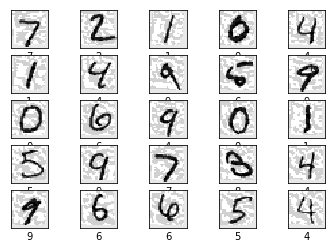

In [142]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(adv_x_np[i][:,:,0], cmap = plt.cm.binary)
    plt.xlabel(np.argmax(preds[i]))

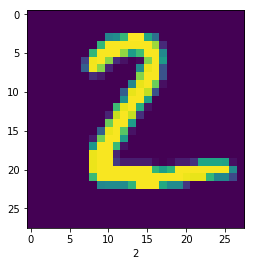

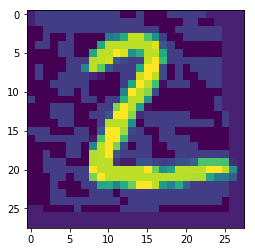

In [143]:
plt.imshow(test_images[1][:,:,0])
plt.xlabel(test_labels[1])
plt.show()
plt.imshow(adv_x_np[1][:,:,0])

### Adversarially train the model with 50% added adversarial examples

In [127]:
with sess.as_default():
    threshold = int(np.round(0.1*n))
    example_indices = range(threshold,n)
    train_indices = range(0, threshold)

    chosen_adv_images = train_images[example_indices]
    chosen_adv_labels = train_labels[example_indices]

    fgsm = FastGradientMethod(model, sess = sess)
    adv_x = fgsm.generate_np(chosen_adv_images, eps = 0.3, clip_min = -1, clip_max = 1)

    new_train = np.vstack((train_images[train_indices], adv_x))
    new_labels = np.hstack((train_labels[train_indices], chosen_adv_labels))

In [150]:
model2 = create_model()
model2.compile(optimizer = tf.train.AdamOptimizer(),
             loss = 'sparse_categorical_crossentropy',
             metrics =['accuracy'])

model2.fit(new_train, new_labels, epochs = 5)

Epoch 1/5
60000/60000 [==============================] - 185s 3ms/step - loss: 0.4514 - acc: 0.8785
Epoch 2/5
60000/60000 [==============================] - 177s 3ms/step - loss: 0.1953 - acc: 0.9501
Epoch 3/5
60000/60000 [==============================] - 163s 3ms/step - loss: 0.1581 - acc: 0.9617
Epoch 4/5
60000/60000 [==============================] - 164s 3ms/step - loss: 0.1397 - acc: 0.9664
Epoch 5/5
60000/60000 [==============================] - 169s 3ms/step - loss: 0.1322 - acc: 0.9680


In [147]:
test_loss, test_acc = model2.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 12s 1ms/step
Test accuracy: 0.9887


In [148]:
acc, adv_x_np, preds = adv_evaluate(model2, 0.3)
print('Test accuracy on adversarial examples:', acc)

10000/10000 [==============================] - 7s 718us/step
Test accuracy on adversarial examples: 0.3533


With 0% adversarial examples - 0.21

With 40% adversarial examples - 0.38

With 60% adversarial examples - 0.4273

## Poison the data [Steinhardt, Koh] Influence functions

In [160]:
def poison_with_influence_proj_gradient_step(model, test_idx, indices_to_poison, 
    projection_fn,
    step_size=0.01,    
    shrink_towards='cluster_center',
    loss_type='normal_loss',
    force_refresh=True, 
    test_description=None,
    output_root=None):
    """
    Returns poisoned_X_train, a subset of model.data_sets.train (marked by indices_to_poison)
    that has been modified by a single gradient step.
    """

    data_sets = model.data_sets

    if test_description is None:
        test_description = test_idx
    grad_filename = os.path.join(output_root, 'grad_influence_wrt_input_val_%s_testidx_%s.npy' % (model.model_name, test_description))

    if (force_refresh == False) and (os.path.exists(grad_filename)):
        grad_influence_wrt_input_val = np.load(grad_filename)
    else:
        grad_influence_wrt_input_val = model.get_grad_of_influence_wrt_input(
            indices_to_poison, 
            test_idx, 
            verbose=False,
            force_refresh=force_refresh,
            test_description=test_description,
            loss_type=loss_type)    

    poisoned_X_train = data_sets.train.x[indices_to_poison, :]
    poisoned_X_train -= step_size * grad_influence_wrt_input_val

    poisoned_labels = data_sets.train.labels[indices_to_poison]        
    poisoned_X_train = projection_fn(poisoned_X_train, poisoned_labels)

    return poisoned_X_train 


def iterative_attack(
    model, 
    indices_to_poison, 
    test_idx, 
    test_description=None,
    step_size=0.01, 
    num_iter=10,
    loss_type='normal_loss',
    projection_fn=None,
    output_root=None,
    stop_after=3): 

    largest_test_loss = 0
    stop_counter = 0

    print('Test idx: %s' % test_idx)

    np.save(os.path.join(output_root, '%s_indices' % model.model_name), indices_to_poison)
    np.savez(os.path.join(output_root, '%s_x_iter-0' % (model.model_name)), 
        poisoned_X_train=model.data_sets.train.x, 
        Y_train=model.data_sets.train.labels)

    for attack_iter in range(num_iter):
        print('*** Iter: %s' % attack_iter)

        # Create modified training dataset        
        old_X_train = np.copy(model.data_sets.train.x)
        poisoned_X_train_subset = poison_with_influence_proj_gradient_step(
            model, 
            test_idx, 
            indices_to_poison,
            projection_fn,
            step_size=step_size,
            loss_type=loss_type,
            force_refresh=True, 
            test_description=test_description,
            output_root=output_root)                
     
        poisoned_X_train = np.copy(model.data_sets.train.x)
        poisoned_X_train[indices_to_poison, :] = poisoned_X_train_subset

        # Measure some metrics on what the gradient step did
        labels = model.data_sets.train.labels
        dists_sum = 0.0
        poisoned_dists_sum = 0.0
        poisoned_mask = np.array([False] * len(labels), dtype=bool)
        poisoned_mask[indices_to_poison] = True
        for y in set(labels):
            cluster_center = np.mean(poisoned_X_train[labels == y, :], axis=0)
            dists = np.linalg.norm(poisoned_X_train[labels == y, :] - cluster_center, axis=1)
            dists_sum += np.sum(dists)

            poisoned_dists = np.linalg.norm(poisoned_X_train[(labels == y) & (poisoned_mask), :] - cluster_center, axis=1)
            poisoned_dists_sum += np.sum(poisoned_dists)

        dists_mean = dists_sum / len(labels)
        poisoned_dists_mean = poisoned_dists_sum / len(indices_to_poison)

        dists_moved = np.linalg.norm(old_X_train[indices_to_poison, :] - poisoned_X_train[indices_to_poison, :], axis=1)
        print('Average distance to cluster center (overall): %s' % dists_mean)
        print('Average distance to cluster center (poisoned): %s' % poisoned_dists_mean)
        print('Average diff in X_train among poisoned indices = %s' % np.mean(dists_moved))
        print('Fraction of 0 gradient points: %s' % np.mean(dists_moved == 0))
        print('Average distance moved by points that moved: %s' % np.mean(dists_moved[dists_moved > 0]))
        
        # Update training dataset
        model.update_train_x(poisoned_X_train)

        # Retrain model
        model.train()

        if (attack_iter + 1) % 40 == 0:

            # Calculate test loss
            test_loss = model.sess.run(model.loss_no_reg, feed_dict=model.all_test_feed_dict)
            if largest_test_loss < test_loss:
                largest_test_loss = test_loss

                np.savez(os.path.join(output_root, '%s_attack' % (model.model_name)), 
                    poisoned_X_train=poisoned_X_train, 
                    Y_train=model.data_sets.train.labels,
                    attack_iter=attack_iter + 1)

                stop_counter = 0
            else:
                stop_counter += 1

            if stop_counter >= stop_after:
                break

In [168]:
import data_utils as data

In [171]:
#Now that we have data_utils and the iterative_attack, we could replicate the code from gradient_attack.py

#Configurations
eps = 0.2
step_size = 0.001
random_seed = 9001

total_copies = int(np.round(eps*train_images.shape[0]))
num_pos_copies = int(total_copies/2)
num_neg_copies = total_copies - num_pos_copies

X_mod, Y_mod = data.copy_random_points(
train_images, train_labels,
target_class = 1,
num_copies = num_pos_copies,
random_seed = random_seed,
replace = True
)

X_mod, Y_mod = data.copy_random_points(
train_images, train_labels,
target_class = -1,
num_copies = num_neg_copies,
random_seed = random_seed,
replace = True)

#provide the influence function model using smoothHinge or whatever

# projection_fn = data.get_projection_fn(
#             X_train, Y_train,
#             sphere=project_sphere,
#             slab=project_slab,
#             percentile=70)


# iterative_attack(
#     model, 
#     indices_to_poison=np.arange(X_train.shape[0], X_modified.shape[0]),            
#     test_idx=None, 
#     test_description=None, 
#     step_size=step_size, 
#     num_iter=2000,
#     loss_type='normal_loss',
#     projection_fn=projection_fn,
#     output_root=output_root)

ValueError: a must be non-empty

# Sub-hypothesis 3